In [328]:
import numpy as np
import pandas as pd
import jieba
from hanziconv import HanziConv
import gensim
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import re
import os
import pickle

from collections import Counter
from itertools import chain

from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [180]:
file_path = r'C:\Users\7153678\Desktop\AI\src\nlp\data\datasource-master\movie_comments.csv'

In [220]:
comment = pd.read_csv(file_path)

C:\ProgramData\Anaconda3\envs\nlp\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [182]:
comment.head(2)

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2


In [221]:
null_index = comment[comment['comment'].isnull()].index
comment.loc[null_index]

,id,link,name,comment,star
49355,48008,https://movie.douban.com/subject/1291824/,黑鹰坠落 Black Hawk Down,NaN,3
49364,48017,https://movie.douban.com/subject/1291824/,黑鹰坠落 Black Hawk Down,NaN,3


In [222]:
# comment.drop(null_index,inplace=True)
comment.dropna(inplace=True)
comment.isnull().sum()

id         0
link       0
name       0
comment    0
star       0
dtype: int64

In [223]:
stop_words_path = r'C:\Users\7153678\Desktop\AI\src\nlp\data\stopword.txt'
stops = set()
with open(stop_words_path, 'r', encoding='utf8') as rf:
    for line in rf:
        stops.add(line.strip())

In [224]:
def is_hanzi_contained(ss):
    pattern = re.compile(r'[\u4E00-\u9FA5]')
    if pattern.findall(ss):
        return True
    else:
        return False
    
def convert_to_simplified(ss):
    return HanziConv.toSimplified(ss)
    
def cut(ss):
    cuts = ''.join(re.findall(r'\w+', ss))
    return jieba.cut(cuts)
    
def clear_web_chars(ss, webs=r'\\n|&nbsp|\xa0|\\xa0|\u3000|\\u3000|\\u0020|\u0020'):
    return re.sub(webs, '', ss)

def clear_stop_words(ss, stops):
    return [s for s in ss if s not in stops]
    
def get_cut_hz(ss):
    ss = convert_to_simplified(ss)
    ss = clear_web_chars(ss)
    ss = list(cut(ss))
#     ss = clear_stop_words(ss, stops)
    if is_hanzi_contained(''.join(ss)):
        return (ss)
    else:
        return None

In [225]:
comment['words'] = comment['comment'].apply(get_cut_hz)

In [226]:
comment.dropna(inplace=True)

In [227]:
Counter(comment['star'])

Counter({1: 12038,
         '1': 12083,
         2: 13517,
         '2': 14059,
         3: 32851,
         '3': 30949,
         4: 41419,
         '4': 39578,
         '5': 30691,
         5: 26151})

In [228]:
comment.drop(comment[comment['star']=='star'].index, inplace=True)

4    80997
3    63800
5    56842
2    27576
1    24121
Name: star, dtype: int64


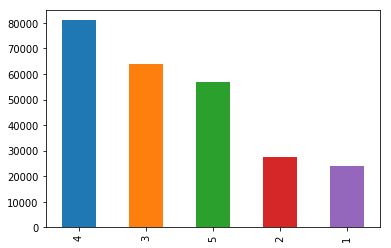

In [229]:
comment['star'] = pd.to_numeric(comment['star'])
star_count = comment['star'].value_counts()
print(star_count)
star_count.plot(kind='bar')

In [252]:
ss = [word for word, count in mini_counter.items() if count < 10]

In [254]:
movie_corpus_w2v_path = os.path.join(os.path.dirname(file_path), 'movie_corpus_w2v.txt')
with open(movie_corpus_w2v_path, 'w', encoding='utf-8') as wf:
    for words in comment['words']:
        try:
            wf.write(' '.join(words) + '\n')   
        except:
            print(words)        

In [255]:
w2v_model_path = r'C:\Users\7153678\Desktop\AI\src\nlp\model\word2vec\word2vec_wiki.model'  # word2vec模型目录的路径, trained by wiki
model = Word2Vec.load(w2v_model_path)

C:\ProgramData\Anaconda3\envs\nlp\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [256]:
sentences = LineSentence(movie_corpus_w2v_path)
model.train(sentences,total_examples=comment.shape[0], epochs=5)
new_model_path = os.path.join(os.path.dirname(w2v_model_path), 'movie_corpus_w2v.model')

C:\ProgramData\Anaconda3\envs\nlp\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [257]:
comment_words = list(chain.from_iterable(comment['words'].tolist()))   
comment_tf = Counter(comment_words)
with open(comment_tf_path, 'wb') as wf:
    pickle.dump(comment_tf, wf, protocol=pickle.HIGHEST_PROTOCOL)

In [258]:
comment_wiki_path = os.path.join(os.path.dirname(movie_corpus_w2v_path), 'wiki_tf.pickle')
with open(comment_wiki_path, 'rb') as rf:
    wiki_tf = pickle.load(rf)

In [259]:
for word in comment_tf:
    wiki_tf[word] += comment_tf[word]

In [260]:
tf_path = os.path.join(os.path.dirname(movie_corpus_w2v_path), 'tf.pickle')
with open(tf_path, 'wb') as wf:
    pickle.dump(wiki_tf, wf, protocol=pickle.HIGHEST_PROTOCOL)

In [261]:
tf = wiki_tf
sentences = comment['words'].tolist()

In [304]:
def sentence_to_vector(sentences, w2v_model, tf, a=1e-3, npc=1):
    s2v = np.zeros([len(sentences), w2v_model.vector_size])
    invalid_indecis = list()
    for i, sentence in enumerate(sentences):
        w2v = np.zeros(w2v_model.vector_size)
        j = 0
        for j, word in enumerate(sentence):
            if word in w2v_model.wv.vocab and word in tf:
                weight = a/(a+tf[word])
                w2v += w2v_model[word]*weight
                j += 1
        if j == 0:
#             print('Invalid index: {}, sentence: {}'.format(i, sentence)) 
            invalid_indecis.append(i)
            continue
        s2v[i,:] = w2v/j
    
    return s2v, invalid_indecis

def remove_pc(s2v, npc=1):
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(s2v)
    u = svd.components_
    s2v = s2v - s2v.dot(u.T).dot(u)
    
    return s2v    

In [266]:
s2v, indecis = sentence_to_vector(sentences, model, tf)

C:\ProgramData\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [300]:
comment_final = comment.reset_index().drop(indecis)

In [305]:
s2v_final = np.delete(s2v, indecis, axis=0)
s2v_final = remove_pc(s2v_final)

In [312]:
star_final = np.array(comment_final['star'])

In [314]:
comment_final.shape, s2v_final.shape, star_final.shape

((251842, 7), (251842, 200), (251842,))

4    80650
3    63400
5    56468
2    27380
1    23944
Name: star, dtype: int64


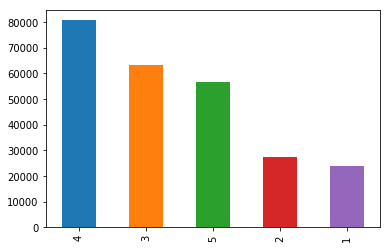

In [307]:
star_count = comment_final['star'].value_counts()
print(star_count)
star_count.plot(kind='bar')

In [407]:
comment_final.sample(20)

,index,id,link,name,comment,star,words
151289,155902,154555,https://movie.douban.com/subject/1292625/,绿野仙踪 The Wizard of Oz,小时候的经典记忆，上次在课上重温，还是那么愉快。话说，其实原著的小画书也很好看。,4,"[小时候, 的, 经典, 记忆, 上次, 在, 课上, 重温, 还是, 那么, 愉快, 话,..."
44866,45973,44626,https://movie.douban.com/subject/5323968/,环太平洋 Pacific Rim,怪兽这么大，地球住得下嘛？,4,"[怪兽, 这么, 大, 地球, 住, 得, 下, 嘛]"
74921,76945,75598,https://movie.douban.com/subject/1921583/,魔术师 L'illusionniste,虐心,4,[虐心]
226253,233307,231960,https://movie.douban.com/subject/1301212/,三匹之侍 三匹の侍,记得以前看过呢。btw，这条三区中文字幕可真差，给负分。,3,"[记得, 以前, 看过, 呢, btw, 这条, 三区, 中文字幕, 可, 真差, 给, 负分]"
228633,235785,234438,https://movie.douban.com/subject/1292055/,再见列宁 Good Bye Lenin!,主角长得很像卡卡,4,"[主角, 长得, 很, 像, 卡卡]"
184601,190405,189058,https://movie.douban.com/subject/1301445/,黑衣人 Men in Black,爆米花元素一应俱全，甚至还有些对人类自身的小调侃，段子和拌嘴很美咖，不错的科幻轻喜。,3,"[爆米花, 元素, 一应俱全, 甚至, 还, 有些, 对, 人类, 自身, 的, 小, 调侃..."
88918,91291,89944,https://movie.douban.com/subject/1293350/,"两杆大烟枪 Lock, Stock and Two Smoking Barrels",电影好帅 OST好酷,5,"[电影, 好帅, OST, 好酷]"
69084,70895,69548,https://movie.douban.com/subject/24743712/,有种你爱我,挺烂的 话说江一燕皮肤真好 挺耐看,2,"[挺烂, 的话, 说江, 一燕, 皮肤, 真好, 挺, 耐看]"
77397,79479,78132,https://movie.douban.com/subject/10604893/,四大名捕大结局,甘道夫什么鬼,2,"[甘道夫, 什么, 鬼]"
37049,37961,36614,https://movie.douban.com/subject/20388224/,绝密跟踪 감시자들,翻拍得有模有样，不过略微装腔作势啊,3,"[翻拍, 得, 有模有样, 不过, 略微, 装腔作势, 啊]"


In [333]:
class_num = 5

In [334]:
data = s2v_final
labels = star_final
data.shape, labels.shape

((251842, 200), (251842,))

In [368]:
train_valid_data, test_data, train_valid_labels, test_labels = train_test_split(data, labels, test_size=0.1,random_state=42)
train_data, valid_data, train_labels, valid_labels = train_test_split(train_valid_data, train_valid_labels, test_size=0.1,random_state=42)
print('train: {} and {}'.format(train_data.shape, train_labels.shape))
print('valid: {} and {}'.format(valid_data.shape, valid_labels.shape))    
print('test: {} and {}'.format(test_data.shape, test_labels.shape))

train: (203991, 200) and (203991,)
valid: (22666, 200) and (22666,)
test: (25185, 200) and (25185,)


In [369]:
def reformat(data, labels):
    new_data = data
    new_label = (labels[:, None] == np.arange(1, class_num+1)).astype(np.float64)
    return new_data, new_label


train_data, train_labels = reformat(train_data, train_labels)
valid_data, valid_labels = reformat(valid_data, valid_labels)
test_data, test_labels = reformat(test_data, test_labels)
print('train: {} and {}'.format(train_data.shape, train_labels.shape))
print('valid: {} and {}'.format(valid_data.shape, valid_labels.shape))    
print('test: {} and {}'.format(test_data.shape, test_labels.shape))   

train: (203991, 200) and (203991, 5)
valid: (22666, 200) and (22666, 5)
test: (25185, 200) and (25185, 5)


In [406]:
valid_labels[1:5]

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [405]:
np.argmax(valid_labels[1:5], axis=1)

array([4, 2, 1, 4], dtype=int64)

In [375]:
def accuracy(predictions, labels):
    return 100.0*sum(np.argmax(predictions, 1)==np.argmax(labels, 1))/labels.shape[0]

In [398]:
batch_size = 500
feature_size = test_data.shape[1]
h1 = 20
beta = 0.01
num_steps = 30001
learn_rate = 0.01
keep_prob = 0.8

In [399]:
g = tf.Graph()
with g.as_default():
    # input, only train is with SGD
    tf_train_data = tf.placeholder(tf.float64, shape=(batch_size, feature_size))
    tf_train_labels = tf.placeholder(tf.float64, shape=(batch_size, class_num))
    tf_valid_data = tf.constant(valid_data)
    tf_test_data = tf.constant(test_data)
    
    # variables
    weights1 = tf.Variable(tf.truncated_normal([feature_size, h1], dtype=np.float64))
    biases1 = tf.Variable(tf.zeros(h1, dtype=np.float64))  
    weights2 = tf.Variable(tf.truncated_normal([h1, class_num], dtype=np.float64))
    biases2 = tf.Variable(tf.zeros(class_num, dtype=np.float64))  
    
    # train compution   
    logits_1 = tf.matmul(tf_train_data, weights1) + biases1
    relu_layer = tf.nn.relu(logits_1)
    dropout_layer = tf.nn.dropout(relu_layer, keep_prob=keep_prob)
    logits_2 = tf.matmul(dropout_layer, weights2) + biases2
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits_2))
    regularization = beta*(tf.nn.l2_loss(weights1) + tf.nn.l2_loss(biases1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(biases2))
    loss = tf.reduce_mean(loss + regularization)

    # optimizer
    optimizer = tf.train.GradientDescentOptimizer(learn_rate).minimize(loss)
    
    # prediction
    train_prediction = tf.nn.softmax(logits_2)
    
    logits_1 = tf.matmul(tf_valid_data, weights1) + biases1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights2) + biases2
    valid_prediction = tf.nn.softmax(logits_2)

    logits_1 = tf.matmul(tf_test_data, weights1) + biases1
    relu_layer = tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights2) + biases2
    test_prediction = tf.nn.softmax(logits_2)
    
with tf.Session(graph=g) as session:
    tf.global_variables_initializer().run()
    print('Initilazed')
    
    for step in range(num_steps):
        offset = (step*batch_size)%(train_labels.shape[0]-batch_size)
        # generate a mini-batch
        batch_data = train_data[offset:(offset+batch_size), :]
        batch_labels = train_labels[offset:(offset+batch_size), :]
        
        # dict to feed mini-batch
        feed_dict = {tf_train_data: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        
        # logging
        if step % 1000 == 0:
            print('Mini-batch train at step {} with loss: {}'.format(step, l))
            print('Mini-batch train accuracy: {}, valid accuracy: {}'.format(
                 accuracy(predictions, batch_labels),
                 accuracy(valid_prediction.eval(), valid_labels)))
    print('Mini-batch test accuarcy: {}'.format(accuracy(test_prediction.eval(), test_labels)))

Initilazed
Mini-batch train at step 0 with loss: 16.996919355000987
Mini-batch train accuracy: 24.4, valid accuracy: 31.81417100502956
Mini-batch train at step 1000 with loss: 14.124478614428556
Mini-batch train accuracy: 33.6, valid accuracy: 31.81417100502956
Mini-batch train at step 2000 with loss: 11.822902005283105
Mini-batch train accuracy: 33.6, valid accuracy: 31.81417100502956
Mini-batch train at step 3000 with loss: 9.94844126650527
Mini-batch train accuracy: 33.0, valid accuracy: 31.81417100502956
Mini-batch train at step 4000 with loss: 8.425868307109615
Mini-batch train accuracy: 30.8, valid accuracy: 31.81417100502956
Mini-batch train at step 5000 with loss: 7.198398443079755
Mini-batch train accuracy: 30.0, valid accuracy: 31.81417100502956
Mini-batch train at step 6000 with loss: 6.1503200744083735
Mini-batch train accuracy: 33.8, valid accuracy: 31.81417100502956
Mini-batch train at step 7000 with loss: 5.334064010507232
Mini-batch train accuracy: 29.6, valid accuracy:

In [382]:
tf.logging.set_verbosity(tf.logging.INFO)
from __future__ import absolute_import, division, print_function, unicode_literals

In [391]:
def cnn_model_fn(features, labels, mode):
    '''Model function of CNN'''
    
    # Input layer
    input_layer = tf.reshape(features['x'], [-1, 10, 20, 1])
    print(input_layer.shape)
    
    # Convolutional layer #1
    conv1 = tf.layers.conv2d(
        inputs = input_layer, 
        filters=32,
        kernel_size=[5, 5], 
        padding='same', 
        activation=tf.nn.relu)
    
    # Pooling layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1, 
        filters=64, 
        kernel_size=[5, 5], 
        padding='same', 
        activation=tf.nn.relu)
      
    # Pooling layer #1
#     pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Dense layer #1
    pool2_flat = tf.reshape(conv2, [-1, 5*10*64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, 
                                training=mode == tf.estimator.ModeKeys.TRAIN)
    
    #Logits layer
    logits = tf.layers.dense(inputs=dropout, units=class_num)
    
    predictions = {
        'classes': tf.argmax(input=logits, axis=1),
        'probabilities': tf.nn.softmax(logits, name='softmax_tensor')
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.05)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
        
    eval_metric_ops = {
        'accuracy': tf.metrics.accuracy(labels=tf.argmax(input=labels, axis=1),
                                        predictions=predictions['classes'])
    }
    return tf.estimator.EstimatorSpec(mode=mode,loss=loss,
                                      eval_metric_ops=eval_metric_ops)


In [392]:
# Create the Estimator
data_root = r'C:\Users\7153678\Desktop\AI\src\nlp\homework\lesson10'
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir=data_root)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_is_chief': True, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002B3D129AB00>, '_session_config': None, '_task_id': 0, '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_tf_random_seed': None, '_train_distribute': None, '_device_fn': None, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_master': '', '_save_checkpoints_steps': None, '_evaluation_master': '', '_num_worker_replicas': 1, '_model_dir': 'C:\\Users\\7153678\\Desktop\\AI\\src\\nlp\\homework\\lesson10', '_save_checkpoints_secs': 600, '_service': None}


In [393]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [394]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

In [395]:
# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
(100, 10, 20, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\7153678\Desktop\AI\src\nlp\homework\lesson10\model.ckpt.
INFO:tensorflow:probabilities = [[0.20000001 0.19999998 0.20000001 0.2        0.2       ]
 [0.20000001 0.19999999 0.20000001 0.2        0.2       ]
 [0.2        0.19999999 0.2        0.2        0.2       ]
 [0.20000001 0.19999999 0.20000002 0.19999999 0.19999999]
 [0.2        0.2        0.2        0.19999999 0.20000001]
 [0.2        0.2        0.20000001 0.2        0.19999999]
 [0.20000001 0.2        0.2        0.2        0.19999999]
 [0.20000001 0.19999998 0.20000002 0.19999999 0.20000001]
 [0.20000001 0.2        0.2        0.19999999 0.2       ]
 [0.2        0.19999999 0.20000001 0.2        0.2       ]
 [0.2        0.1999999

In [396]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": test_data},
    y=test_labels,
    num_epochs=1,
    shuffle=False)

test_results = mnist_classifier.evaluate(input_fn=test_input_fn)
print(test_results)

INFO:tensorflow:Calling model_fn.
(?, 10, 20, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-09-23-12:19:14
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\7153678\Desktop\AI\src\nlp\homework\lesson10\model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-09-23-12:19:45
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.25229302, global_step = 1, loss = 1.6073837
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1: C:\Users\7153678\Desktop\AI\src\nlp\homework\lesson10\model.ckpt-1
{'accuracy': 0.25229302, 'global_step': 1, 'loss': 1.6073837}
